# Implementation
C-splines are typically interpolated from data points. So in a first step we need to convert our image with filamentous
structures somehow to a set of coordinate data points. The way to go is to somehow convert the image into a binary
format i.e. zeroes and ones and reduce the resulting set of pixels to a subset that sufficiently describes the structure
of the line. Then we can pick the coordinates of the remaining pixels and fit a c-spline to them.
Since we are working with python there are already some convinient libraries, which we can use for our image processing
operations. The two most important ones we need here are skimage and pyopencv.

In [1]:
import os
import tifffile as tif
import cv2
import numpy as np
from skimage.morphology import skeletonize_3d
import matplotlib.pyplot as plt

## Extracting the structure of filamentous image data
In a first step we have to convert image data to a set of discrete and connected points. Since we want to fit to a continous line we first blur the image to compensate holes in the structure missing signal. In a second step we convert the image to binary values by applying a thresholding algorithm. We then skeletonize_3d the result to reduce the number of nonzero points in the image. This also gives a first estimate for the center of the line.

In [2]:
with tif.TiffFile(os.path.dirname(os.getcwd()) + r"\test_data\Expansion dSTORM-Line Profile test.tif") as file:
    image = file.asarray().astype(np.uint8)*40

# Less noise and holes -> lower blur
blur = 20
image = cv2.blur(image, (blur, blur))

# build threshold image
ret, thresh = cv2.threshold(image, 0, 1,  cv2.THRESH_OTSU)

# cast to uint8 since cv2 is C++ and sensitive to data types
skeleton = skeletonize_3d(thresh.astype(np.uint8)).astype(np.uint8)
cv2.imshow("skeletonized microtubules", skeleton * 255)
cv2.waitKey(0)

-1

## Converting the skeletonized image to a point set
In a second step we assign the coordinates of remaining pixels to a continous line by using skimages label. The label function assigns an equal number to all pixels !=0 that are either directly (connectivity=1) or diagonally (connectivity=2) connected. Therefore, all pixels in one filament now have the same unique value. Iterating over the maximum value of the label image we can simply collect the coordinates by using the np.where function. By only collecting connected structures of a certain size we discard noise or unconnected signal which made it past the thresholding algorithm.

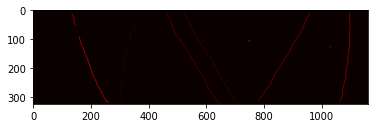

In [3]:
from skimage.measure import label
min_len = 50
colormap = label(skeleton, connectivity=2)
lines = []
for i in range(colormap.max()):
    j = i + 1
    line = np.where(colormap == j)
    if len(line[0]) > min_len:
        lines.append(line)
    else:
        for k in range(line[1].shape[0]):
            skeleton[line[0][k], line[1][k]] = 0
plt.imshow(colormap,cmap="hot")
plt.show()

## Sort the point set and fit it to a c-spline
Sort the points by nearest neighbors (np.where doesn't always give the correct order of the points):

In [4]:
from sklearn.neighbors import NearestNeighbors
import networkx as nx
# pick random line out of our labels
points = np.array(lines[2]).T
# Test if the pointset has the correct shape
if points.shape[1]!=2:
    raise ValueError(f"Wrong pointset dim {points.shape[1]} should be 2")
clf = NearestNeighbors(2).fit(points)
G = clf.kneighbors_graph()
T = nx.from_scipy_sparse_matrix(G)
order = list(nx.dfs_preorder_nodes(T, 0))
points = points[order]

To get a fitting parameterization for our spline coordinates we introduce the dimension z that discribes where we are on the filament. You can imagine this like a coordinate transformation were walking forward means walking along the described structure. z is defined within [0,1] where 0 is the start of the filament and 1 is the end of the filament. Our spline functions describe the transformation from filament space to real space, interpolating y(z) and x(z). We initialize z as 0 and add the commulative distance of neighboring pixels. By dividing by z.max() the coordinate space is normed.

In [5]:
# Compute the normed commulative distance
z = np.zeros(points.shape[0])
z[1:] = np.cumsum(np.sqrt(np.sum(np.diff(points, axis=0) ** 2, axis=1)))
z /= z.max()

Last thing left is to interpolate the splines x(z) and y(z) and their derivatives. This can be done with scipy.interpolate.UnivariateSpline:

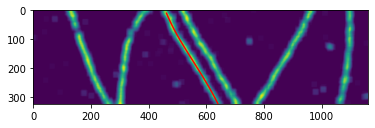

In [6]:
from scipy.interpolate import UnivariateSpline
n= points.shape[0]
smoothing = 3
# Degree of spline: 3 for c-spline
spline_order = 3
# Spline for x and spline for y
splines = [UnivariateSpline(z, coords, k=spline_order, s=n*smoothing) for coords in points.T]
dsplines = [spline.derivative() for spline in splines]
# Code for one spline your have to iterate over all lines to get
# the displayed image
plt.imshow(image)
# Sample [0,1] for spline coordinates
n_samples = np.linspace(0,1,100)
spline_positions = np.array([spl(n_samples) for spl in splines])
# We need these later
dspline_gradients = np.array([spl(n_samples) for spl in dsplines])

plt.plot(spline_positions[1],spline_positions[0], color='red')
plt.show()